![for sale image, from https://time.com/5835778/selling-home-coronavirus/](https://api.time.com/wp-content/uploads/2020/05/selling-home-coronavirus.jpg?w=800&quality=85)

# Project Title

## Overview

A one-paragraph overview of the project, including the business problem, data, methods, results and recommendations.

## Business Problem

Summary of the business problem you are trying to solve, and the data questions that you plan to answer to solve them.

Questions to consider:

- Who are your stakeholders?
- What are your stakeholders' pain points related to this project?
- Why are your predictions important from a business perspective?

## Data Understanding

Describe the data being used for this project.

Questions to consider:

- Where did the data come from, and how do they relate to the data analysis questions?
- What do the data represent? Who is in the sample and what variables are included?
- What is the target variable?
- What are the properties of the variables you intend to use?

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

%matplotlib inline

In [2]:
df = pd.read_csv('data/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
df.info()
# What's the difference btwn sqft_living15/sqft_lot15 and sqft_living/sqft_lot?
# Target variable is price
# Waterfront column is only one with non-null, need to clean that up (assume that null = no waterfront)
# Categorical columns: waterfront, view, condition, grade
# sqft_basement is object, need to convert to numerical format
# for GIS analysis need to find CSR for lat/long

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [4]:
df.describe()
# Looks like there are some extreme outliers in the sqft_lot/sqft_living/bathrooms/bedrooms columns, I am assuming an outlier in one of those columns  means that we'll see similar outliers in the others
# Wonder what .5 floors counts as?
# Looking at yr_built and yr_renovated it looks like the later has a log of properties that have no record of renovation
# Do we want to make a "yr_sold" column just to make comparison btween those variables easier (**FEATURE ENGINEERING!!!**)

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


## Data Preparation

Describe and justify the process for preparing the data for analysis.

Questions to consider:

- Were there variables you dropped or created?
- How did you address missing values or outliers?
- Why are these choices appropriate given the data and the business problem?

## Bedrooms

In [5]:
# dropping any larger then five, presumption being >5 not single family
df = df[df['bedrooms']<6]
df['bedrooms'].value_counts().sort_index()

1     196
2    2760
3    9824
4    6882
5    1601
Name: bedrooms, dtype: int64

## Bathrooms

In [6]:
# clearing out bathrooms over 4 and less than 1 - given distribution these are outliers 
df = df[(df['bathrooms']<=4) & (df['bathrooms']>=1)]
df['bathrooms'].value_counts().sort_index()

1.00    3844
1.25       9
1.50    1437
1.75    3031
2.00    1905
2.25    2029
2.50    5345
2.75    1148
3.00     699
3.25     575
3.50     708
3.75     139
4.00     117
Name: bathrooms, dtype: int64

## Waterfront

In [7]:
# SO few houses meet this criteria it is immaterial
df = df.drop(columns = 'waterfront')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20986 entries, 0 to 21595
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             20986 non-null  int64  
 1   date           20986 non-null  object 
 2   price          20986 non-null  float64
 3   bedrooms       20986 non-null  int64  
 4   bathrooms      20986 non-null  float64
 5   sqft_living    20986 non-null  int64  
 6   sqft_lot       20986 non-null  int64  
 7   floors         20986 non-null  float64
 8   view           20927 non-null  object 
 9   condition      20986 non-null  object 
 10  grade          20986 non-null  object 
 11  sqft_above     20986 non-null  int64  
 12  sqft_basement  20986 non-null  object 
 13  yr_built       20986 non-null  int64  
 14  yr_renovated   17247 non-null  float64
 15  zipcode        20986 non-null  int64  
 16  lat            20986 non-null  float64
 17  long           20986 non-null  float64
 18  sqft_l

## View

In [8]:
# Given distribution we decided this was worth keeping, but we decided to bin the results as 1 = view, 0 = no view
df['view_y_n'] = df['view'].map(lambda x: 0 if x =='NONE' else 1)
df = df.drop(columns = 'view')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20986 entries, 0 to 21595
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             20986 non-null  int64  
 1   date           20986 non-null  object 
 2   price          20986 non-null  float64
 3   bedrooms       20986 non-null  int64  
 4   bathrooms      20986 non-null  float64
 5   sqft_living    20986 non-null  int64  
 6   sqft_lot       20986 non-null  int64  
 7   floors         20986 non-null  float64
 8   condition      20986 non-null  object 
 9   grade          20986 non-null  object 
 10  sqft_above     20986 non-null  int64  
 11  sqft_basement  20986 non-null  object 
 12  yr_built       20986 non-null  int64  
 13  yr_renovated   17247 non-null  float64
 14  zipcode        20986 non-null  int64  
 15  lat            20986 non-null  float64
 16  long           20986 non-null  float64
 17  sqft_living15  20986 non-null  int64  
 18  sqft_l

## Grade

- Removing Luxury and Mansion lines as definition unclear compared to other grades. 
- Removing Low as only 14 houses meet criteria. 
- Keeping single family house in mind as what this table represents.

In [9]:
df = df[(df['grade'] != '13 Mansion') & (df['grade'] != '12 Luxury') & (df['grade'] != '4 Low')]
df['grade'].value_counts()

7 Average        8829
8 Good           5947
9 Better         2556
6 Low Average    2002
10 Very Good     1043
11 Excellent      310
5 Fair            224
Name: grade, dtype: int64

## Year Renovated

In [10]:
# Filling in missing values in this column
df['yr_renovated'] = df['yr_renovated'].fillna(0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20911 entries, 0 to 21595
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             20911 non-null  int64  
 1   date           20911 non-null  object 
 2   price          20911 non-null  float64
 3   bedrooms       20911 non-null  int64  
 4   bathrooms      20911 non-null  float64
 5   sqft_living    20911 non-null  int64  
 6   sqft_lot       20911 non-null  int64  
 7   floors         20911 non-null  float64
 8   condition      20911 non-null  object 
 9   grade          20911 non-null  object 
 10  sqft_above     20911 non-null  int64  
 11  sqft_basement  20911 non-null  object 
 12  yr_built       20911 non-null  int64  
 13  yr_renovated   20911 non-null  float64
 14  zipcode        20911 non-null  int64  
 15  lat            20911 non-null  float64
 16  long           20911 non-null  float64
 17  sqft_living15  20911 non-null  int64  
 18  sqft_l

## Square Footage of the Basement

In [11]:
# Cleaning up the weird '?' values in this column
df['sqft_basement'] = df['sqft_basement'].map(lambda x: 0 if x == '?' else x)
df['sqft_basement'] = pd.to_numeric(df['sqft_basement'])
df['sqft_basement'].value_counts()

0.0       12982
600.0       208
500.0       206
700.0       202
800.0       192
          ...  
243.0         1
1930.0        1
283.0         1
588.0         1
2220.0        1
Name: sqft_basement, Length: 277, dtype: int64

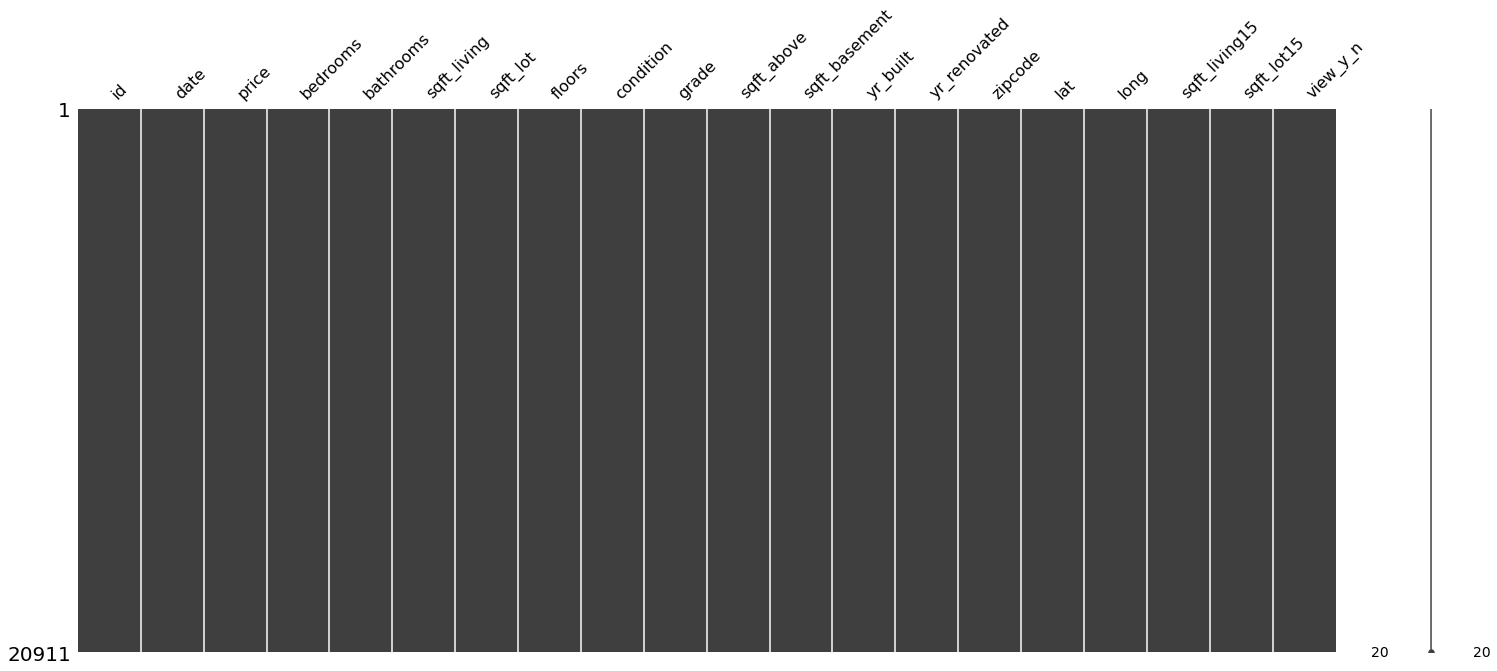

In [12]:
# Including this matrix to visually demonstrate that we have cleaned and dealt with missing values throughout
# the dataframe.
import missingno as msno
msno.matrix(df);

## ADD GIS DATA

- Only one team member had the appropriate libraries installed. For more detailed information, look at **"INSERT NOTEBOOK NAME HERE"**

GIS TO BE ADDED

## One Hot Encoding & Train/Test Split

In [13]:
# Setting up x to include all columns except for price
# Setting up y to be price as our dependent variable
X = df.drop(columns = ['id', 'price'])
y = df['price']

# One Hot Encoder will need this later so we're setting it up now
cat_cols= ['grade', 'condition']

In [14]:
# Setting up train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X, y,  test_size=0.3, random_state=42)

In [22]:
# Settning up OneHotEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
ohe = OneHotEncoder(sparse = False, handle_unknown = 'ignore') 
X_train_ohe = ohe.fit_transform(X_train[cat_cols])

In [23]:
# Setting up a full data frame for visualizations we will use later in the notebook
X_train_ohe_data = pd.DataFrame(X_train_ohe, columns= ohe.get_feature_names(cat_cols), index = X_train.index)
X_train_full = pd.concat([X_train.drop(cat_cols, axis=1), X_train_ohe_data], axis = 1)
X_train_full

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,yr_renovated,...,grade_5 Fair,grade_6 Low Average,grade_7 Average,grade_8 Good,grade_9 Better,condition_Average,condition_Fair,condition_Good,condition_Poor,condition_Very Good
4057,2/13/2015,3,2.50,2090,9847,2.0,2090,0.0,1983,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
18787,5/27/2014,4,2.50,3250,235063,1.0,3250,0.0,1973,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
13863,3/17/2015,3,2.50,2588,5702,2.0,2588,0.0,2008,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
13782,8/7/2014,3,1.75,1710,4080,1.0,1130,580.0,1979,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4321,12/12/2014,4,1.75,1610,11305,1.0,1610,0.0,1968,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11666,12/3/2014,4,1.00,2180,10617,1.5,2180,0.0,1950,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
12373,6/25/2014,3,2.25,2680,9162,1.0,1570,1110.0,1978,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
5588,4/8/2015,2,1.00,820,4206,1.0,820,0.0,1949,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
890,11/10/2014,4,1.00,1820,5400,1.5,1820,0.0,1923,2014.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [25]:
df.to_csv('data/ADD_GIS.csv')

## Modeling

Describe and justify the process for analyzing or modeling the data.

Questions to consider:

- How did you analyze the data to arrive at an initial approach?
- How did you iterate on your initial approach to make it better?
- Why are these choices appropriate given the data and the business problem?

## Evaluation

The evaluation of each model should accompany the creation of each model, and you should be sure to evaluate your models consistently.

Evaluate how well your work solves the stated business problem. 

Questions to consider:

- How do you interpret the results?
- How well does your model fit your data? How much better is this than your baseline model? Is it over or under fit?
- How well does your model/data fit any modeling assumptions?

For the final model, you might also consider:

- How confident are you that your results would generalize beyond the data you have?
- How confident are you that this model would benefit the business if put into use?

### Baseline Understanding

- What does a baseline, model-less prediction look like?

In [15]:
# code here to arrive at a baseline prediction

### First $&(@# Model

Before going too far down the data preparation rabbit hole, be sure to check your work against a first 'substandard' model! What is the easiest way for you to find out how hard your problem is?

In [16]:
# code here for your first 'substandard' model

In [17]:
# code here to evaluate your first 'substandard' model

### Modeling Iterations

Now you can start to use the results of your first model to iterate - there are many options!

In [18]:
# code here to iteratively improve your models

In [19]:
# code here to evaluate your iterations

### 'Final' Model

In the end, you'll arrive at a 'final' model - aka the one you'll use to make your recommendations/conclusions. This likely blends any group work. It might not be the one with the highest scores, but instead might be considered 'final' or 'best' for other reasons.

In [20]:
# code here to show your final model

In [21]:
# code here to evaluate your final model

## Conclusions

Provide your conclusions about the work you've done, including any limitations or next steps.

Questions to consider:

- What would you recommend the business do as a result of this work?
- What are some reasons why your analysis might not fully solve the business problem?
- What else could you do in the future to improve this project (future work)?
